In [1]:
from __future__ import print_function
%load_ext autoreload
%autoreload 2
import os, pickle
from collections import defaultdict, OrderedDict

import numpy as np
import keras.backend as K

import kde
import simplebinmi

%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
sns.set_style('darkgrid')

import utils

# load data network was trained on
trn, tst = utils.get_IB_data('2017_12_21_16_51_3_275766')
# trn, tst = utils.get_mnist()

# calc MI for train and test. Save_activations must have been run with cfg['FULL_MI'] = True
FULL_MI = True

# Which measure to plot
infoplane_measure = 'upper'
# infoplane_measure = 'bin'

DO_SAVE        = True    # Whether to save plots or just show them
DO_LOWER       = (infoplane_measure == 'lower')   # Whether to compute lower bounds also
DO_BINNED      = (infoplane_measure == 'bin')     # Whether to compute MI estimates based on binning

MAX_EPOCHS = 10000      # Max number of epoch for which to compute mutual information measure
NUM_LABELS = 2
# MAX_EPOCHS = 1000
COLORBAR_MAX_EPOCHS = 10000

# Directories from which to load saved layer activity
# ARCH = '1024-20-20-20'
ARCH = '12-10-7-5-4-3-2'
#ARCH = '20-20-20-20-20-20'
#ARCH = '32-28-24-20-16-12'
#ARCH = '32-28-24-20-16-12-8-8'
DIR_TEMPLATE = '%%s_%s'%ARCH

# Functions to return upper and lower bounds on entropy of layer activity
noise_variance = 1e-3                    # Added Gaussian noise variance
binsize = 0.07                           # size of bins for binning method
Klayer_activity = K.placeholder(ndim=2)  # Keras placeholder 
entropy_func_upper = K.function([Klayer_activity,], [kde.entropy_estimator_kl(Klayer_activity, noise_variance),])
entropy_func_lower = K.function([Klayer_activity,], [kde.entropy_estimator_bd(Klayer_activity, noise_variance),])

# nats to bits conversion factor
nats2bits = 1.0/np.log(2) 

# Save indexes of tests data for each of the output classes
saved_labelixs = {}

y = tst.y
Y = tst.Y
if FULL_MI:
    full = utils.construct_full_dataset(trn,tst)
    y = full.y
    Y = full.Y

for i in range(NUM_LABELS):
    saved_labelixs[i] = y == i

labelprobs = np.mean(Y, axis=0)

Using TensorFlow backend.


In [2]:
PLOT_LAYERS    = None     # Which layers to plot.  If None, all saved layers are plotted 

# Data structure used to store results
measures = OrderedDict()
measures['tanh'] = {}
measures['relu'] = {}
# measures['softsign'] = {}
# measures['softplus'] = {}

Compute MI measures
-----

In [3]:
for activation in measures.keys():
    cur_dir = 'rawdata/' + DIR_TEMPLATE % activation
    if not os.path.exists(cur_dir):
        print("Directory %s not found" % cur_dir)
        continue
        
    # Load files saved during each epoch, and compute MI measures of the activity in that epoch
    print('*** Doing %s ***' % cur_dir)
    for epochfile in sorted(os.listdir(cur_dir)):
        if not epochfile.startswith('epoch'):
            continue
            
        fname = cur_dir + "/" + epochfile
        with open(fname, 'rb') as f:
            d = pickle.load(f)

        epoch = d['epoch']
        if epoch in measures[activation]: # Skip this epoch if its already been processed
            continue                      # this is a trick to allow us to rerun this cell multiple times)
            
        if epoch > MAX_EPOCHS:
            continue

        print("Doing", fname)
        
        num_layers = len(d['data']['activity_tst'])

        if PLOT_LAYERS is None:
            PLOT_LAYERS = []
            for lndx in range(num_layers):
                #if d['data']['activity_tst'][lndx].shape[1] < 200 and lndx != num_layers - 1:
                PLOT_LAYERS.append(lndx)
                
        cepochdata = defaultdict(list)
        for lndx in range(num_layers):
            activity = d['data']['activity_tst'][lndx]

            # Compute marginal entropies
            h_upper = entropy_func_upper([activity,])[0]
            if DO_LOWER:
                h_lower = entropy_func_lower([activity,])[0]
                
            # Layer activity given input. This is simply the entropy of the Gaussian noise
            hM_given_X = kde.kde_condentropy(activity, noise_variance)

            # Compute conditional entropies of layer activity given output
            hM_given_Y_upper=0.
            for i in range(NUM_LABELS):
                hcond_upper = entropy_func_upper([activity[saved_labelixs[i],:],])[0]
                hM_given_Y_upper += labelprobs[i] * hcond_upper
                
            if DO_LOWER:
                hM_given_Y_lower=0.
                for i in range(NUM_LABELS):
                    hcond_lower = entropy_func_lower([activity[saved_labelixs[i],:],])[0]
                    hM_given_Y_lower += labelprobs[i] * hcond_lower
                
            cepochdata['MI_XM_upper'].append( nats2bits * (h_upper - hM_given_X) )
            cepochdata['MI_YM_upper'].append( nats2bits * (h_upper - hM_given_Y_upper) )
            cepochdata['H_M_upper'  ].append( nats2bits * h_upper )

            pstr = 'upper: MI(X;M)=%0.3f, MI(Y;M)=%0.3f' % (cepochdata['MI_XM_upper'][-1], cepochdata['MI_YM_upper'][-1])
            if DO_LOWER:  # Compute lower bounds
                cepochdata['MI_XM_lower'].append( nats2bits * (h_lower - hM_given_X) )
                cepochdata['MI_YM_lower'].append( nats2bits * (h_lower - hM_given_Y_lower) )
                cepochdata['H_M_lower'  ].append( nats2bits * h_lower )
                pstr += ' | lower: MI(X;M)=%0.3f, MI(Y;M)=%0.3f' % (cepochdata['MI_XM_lower'][-1], cepochdata['MI_YM_lower'][-1])

            if DO_BINNED: # Compute binned estimates
                binxm, binym = simplebinmi.bin_calc_information2(saved_labelixs, activity, binsize)
                cepochdata['MI_XM_bin'].append( nats2bits * binxm )
                cepochdata['MI_YM_bin'].append( nats2bits * binym )
                pstr += ' | bin: MI(X;M)=%0.3f, MI(Y;M)=%0.3f' % (cepochdata['MI_XM_bin'][-1], cepochdata['MI_YM_bin'][-1])
                        
            print('- Layer %d %s' % (lndx, pstr) )

        measures[activation][epoch] = cepochdata

*** Doing rawdata/tanh_12-10-7-5-4-3-2 ***
Doing rawdata/tanh_12-10-7-5-4-3-2/epoch00000000
- Layer 0 upper: MI(X;M)=12.000, MI(Y;M)=0.999
- Layer 1 upper: MI(X;M)=12.000, MI(Y;M)=0.999
- Layer 2 upper: MI(X;M)=11.979, MI(Y;M)=0.994
- Layer 3 upper: MI(X;M)=10.628, MI(Y;M)=0.587
- Layer 4 upper: MI(X;M)=7.943, MI(Y;M)=0.187
- Layer 5 upper: MI(X;M)=6.423, MI(Y;M)=0.090
- Layer 6 upper: MI(X;M)=5.450, MI(Y;M)=0.050
- Layer 7 upper: MI(X;M)=1.084, MI(Y;M)=0.006
Doing rawdata/tanh_12-10-7-5-4-3-2/epoch00000001
- Layer 0 upper: MI(X;M)=12.000, MI(Y;M)=0.999
- Layer 1 upper: MI(X;M)=12.000, MI(Y;M)=0.999
- Layer 2 upper: MI(X;M)=11.969, MI(Y;M)=0.990
- Layer 3 upper: MI(X;M)=10.493, MI(Y;M)=0.570
- Layer 4 upper: MI(X;M)=7.795, MI(Y;M)=0.197
- Layer 5 upper: MI(X;M)=6.282, MI(Y;M)=0.107
- Layer 6 upper: MI(X;M)=5.352, MI(Y;M)=0.055
- Layer 7 upper: MI(X;M)=1.059, MI(Y;M)=0.011
Doing rawdata/tanh_12-10-7-5-4-3-2/epoch00000002
- Layer 0 upper: MI(X;M)=12.000, MI(Y;M)=0.999
- Layer 1 upper: MI

- Layer 7 upper: MI(X;M)=3.354, MI(Y;M)=0.560
Doing rawdata/tanh_12-10-7-5-4-3-2/epoch00000020
- Layer 0 upper: MI(X;M)=12.000, MI(Y;M)=0.999
- Layer 1 upper: MI(X;M)=12.000, MI(Y;M)=0.999
- Layer 2 upper: MI(X;M)=11.823, MI(Y;M)=0.980
- Layer 3 upper: MI(X;M)=9.935, MI(Y;M)=0.753
- Layer 4 upper: MI(X;M)=8.388, MI(Y;M)=0.647
- Layer 5 upper: MI(X;M)=7.315, MI(Y;M)=0.618
- Layer 6 upper: MI(X;M)=7.089, MI(Y;M)=0.616
- Layer 7 upper: MI(X;M)=3.397, MI(Y;M)=0.580
Doing rawdata/tanh_12-10-7-5-4-3-2/epoch00000025
- Layer 0 upper: MI(X;M)=12.000, MI(Y;M)=0.999
- Layer 1 upper: MI(X;M)=12.000, MI(Y;M)=0.999
- Layer 2 upper: MI(X;M)=11.823, MI(Y;M)=0.982
- Layer 3 upper: MI(X;M)=9.857, MI(Y;M)=0.784
- Layer 4 upper: MI(X;M)=8.302, MI(Y;M)=0.697
- Layer 5 upper: MI(X;M)=7.027, MI(Y;M)=0.665
- Layer 6 upper: MI(X;M)=6.630, MI(Y;M)=0.663
- Layer 7 upper: MI(X;M)=3.301, MI(Y;M)=0.625
Doing rawdata/tanh_12-10-7-5-4-3-2/epoch00000030
- Layer 0 upper: MI(X;M)=12.000, MI(Y;M)=0.999
- Layer 1 upper: M

- Layer 4 upper: MI(X;M)=9.126, MI(Y;M)=0.858
- Layer 5 upper: MI(X;M)=7.287, MI(Y;M)=0.832
- Layer 6 upper: MI(X;M)=5.420, MI(Y;M)=0.829
- Layer 7 upper: MI(X;M)=2.607, MI(Y;M)=0.774
Doing rawdata/tanh_12-10-7-5-4-3-2/epoch00000180
- Layer 0 upper: MI(X;M)=12.000, MI(Y;M)=0.999
- Layer 1 upper: MI(X;M)=12.000, MI(Y;M)=0.999
- Layer 2 upper: MI(X;M)=11.946, MI(Y;M)=0.998
- Layer 3 upper: MI(X;M)=10.709, MI(Y;M)=0.928
- Layer 4 upper: MI(X;M)=9.250, MI(Y;M)=0.871
- Layer 5 upper: MI(X;M)=7.372, MI(Y;M)=0.845
- Layer 6 upper: MI(X;M)=5.409, MI(Y;M)=0.841
- Layer 7 upper: MI(X;M)=2.542, MI(Y;M)=0.788
Doing rawdata/tanh_12-10-7-5-4-3-2/epoch00000200
- Layer 0 upper: MI(X;M)=12.000, MI(Y;M)=0.999
- Layer 1 upper: MI(X;M)=12.000, MI(Y;M)=0.999
- Layer 2 upper: MI(X;M)=11.950, MI(Y;M)=0.998
- Layer 3 upper: MI(X;M)=10.780, MI(Y;M)=0.937
- Layer 4 upper: MI(X;M)=9.355, MI(Y;M)=0.883
- Layer 5 upper: MI(X;M)=7.442, MI(Y;M)=0.860
- Layer 6 upper: MI(X;M)=5.406, MI(Y;M)=0.858
- Layer 7 upper: MI(

- Layer 3 upper: MI(X;M)=11.213, MI(Y;M)=0.978
- Layer 4 upper: MI(X;M)=10.014, MI(Y;M)=0.957
- Layer 5 upper: MI(X;M)=7.755, MI(Y;M)=0.942
- Layer 6 upper: MI(X;M)=4.946, MI(Y;M)=0.940
- Layer 7 upper: MI(X;M)=1.880, MI(Y;M)=0.894
Doing rawdata/tanh_12-10-7-5-4-3-2/epoch00000580
- Layer 0 upper: MI(X;M)=12.000, MI(Y;M)=0.999
- Layer 1 upper: MI(X;M)=12.000, MI(Y;M)=0.999
- Layer 2 upper: MI(X;M)=11.982, MI(Y;M)=0.999
- Layer 3 upper: MI(X;M)=11.230, MI(Y;M)=0.979
- Layer 4 upper: MI(X;M)=10.051, MI(Y;M)=0.958
- Layer 5 upper: MI(X;M)=7.803, MI(Y;M)=0.946
- Layer 6 upper: MI(X;M)=4.982, MI(Y;M)=0.945
- Layer 7 upper: MI(X;M)=1.887, MI(Y;M)=0.897
Doing rawdata/tanh_12-10-7-5-4-3-2/epoch00000600
- Layer 0 upper: MI(X;M)=12.000, MI(Y;M)=0.999
- Layer 1 upper: MI(X;M)=12.000, MI(Y;M)=0.999
- Layer 2 upper: MI(X;M)=11.982, MI(Y;M)=0.999
- Layer 3 upper: MI(X;M)=11.227, MI(Y;M)=0.979
- Layer 4 upper: MI(X;M)=10.061, MI(Y;M)=0.959
- Layer 5 upper: MI(X;M)=7.825, MI(Y;M)=0.948
- Layer 6 upper:

- Layer 1 upper: MI(X;M)=12.000, MI(Y;M)=0.999
- Layer 2 upper: MI(X;M)=11.976, MI(Y;M)=0.999
- Layer 3 upper: MI(X;M)=11.289, MI(Y;M)=0.984
- Layer 4 upper: MI(X;M)=10.205, MI(Y;M)=0.967
- Layer 5 upper: MI(X;M)=7.851, MI(Y;M)=0.960
- Layer 6 upper: MI(X;M)=4.754, MI(Y;M)=0.961
- Layer 7 upper: MI(X;M)=1.717, MI(Y;M)=0.917
Doing rawdata/tanh_12-10-7-5-4-3-2/epoch00000980
- Layer 0 upper: MI(X;M)=12.000, MI(Y;M)=0.999
- Layer 1 upper: MI(X;M)=11.999, MI(Y;M)=0.999
- Layer 2 upper: MI(X;M)=11.976, MI(Y;M)=0.999
- Layer 3 upper: MI(X;M)=11.299, MI(Y;M)=0.984
- Layer 4 upper: MI(X;M)=10.212, MI(Y;M)=0.967
- Layer 5 upper: MI(X;M)=7.845, MI(Y;M)=0.961
- Layer 6 upper: MI(X;M)=4.734, MI(Y;M)=0.961
- Layer 7 upper: MI(X;M)=1.732, MI(Y;M)=0.916
Doing rawdata/tanh_12-10-7-5-4-3-2/epoch00001000
- Layer 0 upper: MI(X;M)=12.000, MI(Y;M)=0.999
- Layer 1 upper: MI(X;M)=11.999, MI(Y;M)=0.999
- Layer 2 upper: MI(X;M)=11.975, MI(Y;M)=0.999
- Layer 3 upper: MI(X;M)=11.281, MI(Y;M)=0.983
- Layer 4 upper

- Layer 3 upper: MI(X;M)=11.332, MI(Y;M)=0.988
- Layer 4 upper: MI(X;M)=10.029, MI(Y;M)=0.979
- Layer 5 upper: MI(X;M)=7.337, MI(Y;M)=0.971
- Layer 6 upper: MI(X;M)=3.940, MI(Y;M)=0.967
- Layer 7 upper: MI(X;M)=1.497, MI(Y;M)=0.928
Doing rawdata/tanh_12-10-7-5-4-3-2/epoch00001380
- Layer 0 upper: MI(X;M)=12.000, MI(Y;M)=0.999
- Layer 1 upper: MI(X;M)=11.999, MI(Y;M)=0.999
- Layer 2 upper: MI(X;M)=11.978, MI(Y;M)=0.999
- Layer 3 upper: MI(X;M)=11.332, MI(Y;M)=0.988
- Layer 4 upper: MI(X;M)=10.019, MI(Y;M)=0.980
- Layer 5 upper: MI(X;M)=7.318, MI(Y;M)=0.973
- Layer 6 upper: MI(X;M)=3.902, MI(Y;M)=0.968
- Layer 7 upper: MI(X;M)=1.483, MI(Y;M)=0.926
Doing rawdata/tanh_12-10-7-5-4-3-2/epoch00001400
- Layer 0 upper: MI(X;M)=12.000, MI(Y;M)=0.999
- Layer 1 upper: MI(X;M)=11.999, MI(Y;M)=0.999
- Layer 2 upper: MI(X;M)=11.978, MI(Y;M)=0.999
- Layer 3 upper: MI(X;M)=11.332, MI(Y;M)=0.988
- Layer 4 upper: MI(X;M)=9.999, MI(Y;M)=0.979
- Layer 5 upper: MI(X;M)=7.294, MI(Y;M)=0.970
- Layer 6 upper: 

- Layer 1 upper: MI(X;M)=12.000, MI(Y;M)=0.999
- Layer 2 upper: MI(X;M)=11.982, MI(Y;M)=0.999
- Layer 3 upper: MI(X;M)=11.344, MI(Y;M)=0.990
- Layer 4 upper: MI(X;M)=9.689, MI(Y;M)=0.986
- Layer 5 upper: MI(X;M)=6.788, MI(Y;M)=0.979
- Layer 6 upper: MI(X;M)=3.235, MI(Y;M)=0.971
- Layer 7 upper: MI(X;M)=1.315, MI(Y;M)=0.939
Doing rawdata/tanh_12-10-7-5-4-3-2/epoch00001780
- Layer 0 upper: MI(X;M)=12.000, MI(Y;M)=0.999
- Layer 1 upper: MI(X;M)=12.000, MI(Y;M)=0.999
- Layer 2 upper: MI(X;M)=11.983, MI(Y;M)=0.999
- Layer 3 upper: MI(X;M)=11.347, MI(Y;M)=0.989
- Layer 4 upper: MI(X;M)=9.675, MI(Y;M)=0.986
- Layer 5 upper: MI(X;M)=6.736, MI(Y;M)=0.982
- Layer 6 upper: MI(X;M)=3.180, MI(Y;M)=0.974
- Layer 7 upper: MI(X;M)=1.319, MI(Y;M)=0.937
Doing rawdata/tanh_12-10-7-5-4-3-2/epoch00001800
- Layer 0 upper: MI(X;M)=12.000, MI(Y;M)=0.999
- Layer 1 upper: MI(X;M)=12.000, MI(Y;M)=0.999
- Layer 2 upper: MI(X;M)=11.982, MI(Y;M)=0.999
- Layer 3 upper: MI(X;M)=11.336, MI(Y;M)=0.989
- Layer 4 upper: 

- Layer 4 upper: MI(X;M)=9.252, MI(Y;M)=0.986
- Layer 5 upper: MI(X;M)=5.707, MI(Y;M)=0.980
- Layer 6 upper: MI(X;M)=2.360, MI(Y;M)=0.967
- Layer 7 upper: MI(X;M)=1.121, MI(Y;M)=0.934
Doing rawdata/tanh_12-10-7-5-4-3-2/epoch00002900
- Layer 0 upper: MI(X;M)=12.000, MI(Y;M)=0.999
- Layer 1 upper: MI(X;M)=12.000, MI(Y;M)=0.999
- Layer 2 upper: MI(X;M)=11.983, MI(Y;M)=0.999
- Layer 3 upper: MI(X;M)=11.261, MI(Y;M)=0.990
- Layer 4 upper: MI(X;M)=9.242, MI(Y;M)=0.987
- Layer 5 upper: MI(X;M)=5.644, MI(Y;M)=0.984
- Layer 6 upper: MI(X;M)=2.320, MI(Y;M)=0.970
- Layer 7 upper: MI(X;M)=1.046, MI(Y;M)=0.943
Doing rawdata/tanh_12-10-7-5-4-3-2/epoch00003000
- Layer 0 upper: MI(X;M)=12.000, MI(Y;M)=0.999
- Layer 1 upper: MI(X;M)=12.000, MI(Y;M)=0.999
- Layer 2 upper: MI(X;M)=11.983, MI(Y;M)=0.999
- Layer 3 upper: MI(X;M)=11.250, MI(Y;M)=0.990
- Layer 4 upper: MI(X;M)=9.148, MI(Y;M)=0.986
- Layer 5 upper: MI(X;M)=5.413, MI(Y;M)=0.983
- Layer 6 upper: MI(X;M)=2.187, MI(Y;M)=0.968
- Layer 7 upper: MI(

- Layer 1 upper: MI(X;M)=12.000, MI(Y;M)=0.999
- Layer 2 upper: MI(X;M)=11.983, MI(Y;M)=0.999
- Layer 3 upper: MI(X;M)=11.272, MI(Y;M)=0.992
- Layer 4 upper: MI(X;M)=8.809, MI(Y;M)=0.987
- Layer 5 upper: MI(X;M)=5.002, MI(Y;M)=0.982
- Layer 6 upper: MI(X;M)=1.940, MI(Y;M)=0.965
- Layer 7 upper: MI(X;M)=1.025, MI(Y;M)=0.945
Doing rawdata/tanh_12-10-7-5-4-3-2/epoch00004900
- Layer 0 upper: MI(X;M)=12.000, MI(Y;M)=0.999
- Layer 1 upper: MI(X;M)=12.000, MI(Y;M)=0.999
- Layer 2 upper: MI(X;M)=11.983, MI(Y;M)=0.999
- Layer 3 upper: MI(X;M)=11.254, MI(Y;M)=0.992
- Layer 4 upper: MI(X;M)=8.924, MI(Y;M)=0.986
- Layer 5 upper: MI(X;M)=5.406, MI(Y;M)=0.982
- Layer 6 upper: MI(X;M)=2.231, MI(Y;M)=0.968
- Layer 7 upper: MI(X;M)=1.040, MI(Y;M)=0.947
Doing rawdata/tanh_12-10-7-5-4-3-2/epoch00005000
- Layer 0 upper: MI(X;M)=12.000, MI(Y;M)=0.999
- Layer 1 upper: MI(X;M)=12.000, MI(Y;M)=0.999
- Layer 2 upper: MI(X;M)=11.983, MI(Y;M)=0.999
- Layer 3 upper: MI(X;M)=11.270, MI(Y;M)=0.992
- Layer 4 upper: 

- Layer 4 upper: MI(X;M)=8.662, MI(Y;M)=0.988
- Layer 5 upper: MI(X;M)=4.657, MI(Y;M)=0.984
- Layer 6 upper: MI(X;M)=1.732, MI(Y;M)=0.965
- Layer 7 upper: MI(X;M)=1.024, MI(Y;M)=0.947
Doing rawdata/tanh_12-10-7-5-4-3-2/epoch00006900
- Layer 0 upper: MI(X;M)=12.000, MI(Y;M)=0.999
- Layer 1 upper: MI(X;M)=12.000, MI(Y;M)=0.999
- Layer 2 upper: MI(X;M)=11.982, MI(Y;M)=0.999
- Layer 3 upper: MI(X;M)=11.250, MI(Y;M)=0.993
- Layer 4 upper: MI(X;M)=8.579, MI(Y;M)=0.988
- Layer 5 upper: MI(X;M)=4.527, MI(Y;M)=0.984
- Layer 6 upper: MI(X;M)=1.675, MI(Y;M)=0.964
- Layer 7 upper: MI(X;M)=1.022, MI(Y;M)=0.946
Doing rawdata/tanh_12-10-7-5-4-3-2/epoch00007000
- Layer 0 upper: MI(X;M)=12.000, MI(Y;M)=0.999
- Layer 1 upper: MI(X;M)=12.000, MI(Y;M)=0.999
- Layer 2 upper: MI(X;M)=11.982, MI(Y;M)=0.999
- Layer 3 upper: MI(X;M)=11.247, MI(Y;M)=0.993
- Layer 4 upper: MI(X;M)=8.498, MI(Y;M)=0.988
- Layer 5 upper: MI(X;M)=4.405, MI(Y;M)=0.983
- Layer 6 upper: MI(X;M)=1.624, MI(Y;M)=0.964
- Layer 7 upper: MI(

- Layer 5 upper: MI(X;M)=5.729, MI(Y;M)=0.214
- Layer 6 upper: MI(X;M)=5.262, MI(Y;M)=0.201
- Layer 7 upper: MI(X;M)=2.268, MI(Y;M)=0.163
Doing rawdata/relu_12-10-7-5-4-3-2/epoch00000009
- Layer 0 upper: MI(X;M)=11.989, MI(Y;M)=0.996
- Layer 1 upper: MI(X;M)=11.591, MI(Y;M)=0.884
- Layer 2 upper: MI(X;M)=10.245, MI(Y;M)=0.597
- Layer 3 upper: MI(X;M)=8.451, MI(Y;M)=0.356
- Layer 4 upper: MI(X;M)=6.380, MI(Y;M)=0.253
- Layer 5 upper: MI(X;M)=5.838, MI(Y;M)=0.237
- Layer 6 upper: MI(X;M)=5.350, MI(Y;M)=0.228
- Layer 7 upper: MI(X;M)=2.364, MI(Y;M)=0.185
Doing rawdata/relu_12-10-7-5-4-3-2/epoch00000010
- Layer 0 upper: MI(X;M)=11.991, MI(Y;M)=0.996
- Layer 1 upper: MI(X;M)=11.655, MI(Y;M)=0.902
- Layer 2 upper: MI(X;M)=10.502, MI(Y;M)=0.652
- Layer 3 upper: MI(X;M)=8.718, MI(Y;M)=0.402
- Layer 4 upper: MI(X;M)=6.511, MI(Y;M)=0.280
- Layer 5 upper: MI(X;M)=5.957, MI(Y;M)=0.265
- Layer 6 upper: MI(X;M)=5.458, MI(Y;M)=0.254
- Layer 7 upper: MI(X;M)=2.481, MI(Y;M)=0.210
Doing rawdata/relu_12-

- Layer 4 upper: MI(X;M)=7.077, MI(Y;M)=0.724
- Layer 5 upper: MI(X;M)=6.094, MI(Y;M)=0.705
- Layer 6 upper: MI(X;M)=5.437, MI(Y;M)=0.688
- Layer 7 upper: MI(X;M)=2.668, MI(Y;M)=0.667
Doing rawdata/relu_12-10-7-5-4-3-2/epoch00000070
- Layer 0 upper: MI(X;M)=12.000, MI(Y;M)=0.999
- Layer 1 upper: MI(X;M)=11.953, MI(Y;M)=0.991
- Layer 2 upper: MI(X;M)=11.676, MI(Y;M)=0.961
- Layer 3 upper: MI(X;M)=10.228, MI(Y;M)=0.866
- Layer 4 upper: MI(X;M)=7.000, MI(Y;M)=0.728
- Layer 5 upper: MI(X;M)=6.001, MI(Y;M)=0.709
- Layer 6 upper: MI(X;M)=5.326, MI(Y;M)=0.688
- Layer 7 upper: MI(X;M)=2.635, MI(Y;M)=0.666
Doing rawdata/relu_12-10-7-5-4-3-2/epoch00000075
- Layer 0 upper: MI(X;M)=12.000, MI(Y;M)=0.999
- Layer 1 upper: MI(X;M)=11.952, MI(Y;M)=0.990
- Layer 2 upper: MI(X;M)=11.670, MI(Y;M)=0.960
- Layer 3 upper: MI(X;M)=10.231, MI(Y;M)=0.868
- Layer 4 upper: MI(X;M)=7.029, MI(Y;M)=0.734
- Layer 5 upper: MI(X;M)=6.026, MI(Y;M)=0.714
- Layer 6 upper: MI(X;M)=5.365, MI(Y;M)=0.698
- Layer 7 upper: MI(

- Layer 5 upper: MI(X;M)=6.100, MI(Y;M)=0.824
- Layer 6 upper: MI(X;M)=5.629, MI(Y;M)=0.816
- Layer 7 upper: MI(X;M)=2.059, MI(Y;M)=0.801
Doing rawdata/relu_12-10-7-5-4-3-2/epoch00000380
- Layer 0 upper: MI(X;M)=11.999, MI(Y;M)=0.999
- Layer 1 upper: MI(X;M)=11.897, MI(Y;M)=0.992
- Layer 2 upper: MI(X;M)=11.384, MI(Y;M)=0.967
- Layer 3 upper: MI(X;M)=9.921, MI(Y;M)=0.927
- Layer 4 upper: MI(X;M)=7.017, MI(Y;M)=0.839
- Layer 5 upper: MI(X;M)=6.167, MI(Y;M)=0.830
- Layer 6 upper: MI(X;M)=5.720, MI(Y;M)=0.820
- Layer 7 upper: MI(X;M)=2.055, MI(Y;M)=0.804
Doing rawdata/relu_12-10-7-5-4-3-2/epoch00000400
- Layer 0 upper: MI(X;M)=11.999, MI(Y;M)=0.999
- Layer 1 upper: MI(X;M)=11.902, MI(Y;M)=0.992
- Layer 2 upper: MI(X;M)=11.391, MI(Y;M)=0.968
- Layer 3 upper: MI(X;M)=9.933, MI(Y;M)=0.927
- Layer 4 upper: MI(X;M)=7.032, MI(Y;M)=0.841
- Layer 5 upper: MI(X;M)=6.160, MI(Y;M)=0.831
- Layer 6 upper: MI(X;M)=5.660, MI(Y;M)=0.820
- Layer 7 upper: MI(X;M)=2.054, MI(Y;M)=0.804
Doing rawdata/relu_12-

- Layer 3 upper: MI(X;M)=10.020, MI(Y;M)=0.963
- Layer 4 upper: MI(X;M)=7.121, MI(Y;M)=0.908
- Layer 5 upper: MI(X;M)=6.203, MI(Y;M)=0.898
- Layer 6 upper: MI(X;M)=6.051, MI(Y;M)=0.897
- Layer 7 upper: MI(X;M)=1.931, MI(Y;M)=0.878
Doing rawdata/relu_12-10-7-5-4-3-2/epoch00000780
- Layer 0 upper: MI(X;M)=11.999, MI(Y;M)=0.999
- Layer 1 upper: MI(X;M)=11.901, MI(Y;M)=0.996
- Layer 2 upper: MI(X;M)=11.469, MI(Y;M)=0.985
- Layer 3 upper: MI(X;M)=10.043, MI(Y;M)=0.967
- Layer 4 upper: MI(X;M)=7.170, MI(Y;M)=0.919
- Layer 5 upper: MI(X;M)=6.174, MI(Y;M)=0.908
- Layer 6 upper: MI(X;M)=6.058, MI(Y;M)=0.908
- Layer 7 upper: MI(X;M)=1.876, MI(Y;M)=0.890
Doing rawdata/relu_12-10-7-5-4-3-2/epoch00000800
- Layer 0 upper: MI(X;M)=11.999, MI(Y;M)=0.999
- Layer 1 upper: MI(X;M)=11.893, MI(Y;M)=0.997
- Layer 2 upper: MI(X;M)=11.467, MI(Y;M)=0.987
- Layer 3 upper: MI(X;M)=10.055, MI(Y;M)=0.971
- Layer 4 upper: MI(X;M)=7.205, MI(Y;M)=0.931
- Layer 5 upper: MI(X;M)=6.270, MI(Y;M)=0.919
- Layer 6 upper: MI

- Layer 4 upper: MI(X;M)=7.481, MI(Y;M)=0.963
- Layer 5 upper: MI(X;M)=6.210, MI(Y;M)=0.955
- Layer 6 upper: MI(X;M)=5.994, MI(Y;M)=0.955
- Layer 7 upper: MI(X;M)=1.404, MI(Y;M)=0.930
Doing rawdata/relu_12-10-7-5-4-3-2/epoch00001180
- Layer 0 upper: MI(X;M)=11.995, MI(Y;M)=0.999
- Layer 1 upper: MI(X;M)=11.874, MI(Y;M)=0.997
- Layer 2 upper: MI(X;M)=11.419, MI(Y;M)=0.991
- Layer 3 upper: MI(X;M)=10.070, MI(Y;M)=0.984
- Layer 4 upper: MI(X;M)=7.522, MI(Y;M)=0.963
- Layer 5 upper: MI(X;M)=6.247, MI(Y;M)=0.955
- Layer 6 upper: MI(X;M)=6.031, MI(Y;M)=0.954
- Layer 7 upper: MI(X;M)=1.380, MI(Y;M)=0.928
Doing rawdata/relu_12-10-7-5-4-3-2/epoch00001200
- Layer 0 upper: MI(X;M)=11.995, MI(Y;M)=0.999
- Layer 1 upper: MI(X;M)=11.875, MI(Y;M)=0.997
- Layer 2 upper: MI(X;M)=11.416, MI(Y;M)=0.991
- Layer 3 upper: MI(X;M)=10.059, MI(Y;M)=0.984
- Layer 4 upper: MI(X;M)=7.499, MI(Y;M)=0.963
- Layer 5 upper: MI(X;M)=6.208, MI(Y;M)=0.954
- Layer 6 upper: MI(X;M)=5.970, MI(Y;M)=0.952
- Layer 7 upper: MI(

- Layer 3 upper: MI(X;M)=10.241, MI(Y;M)=0.988
- Layer 4 upper: MI(X;M)=7.889, MI(Y;M)=0.973
- Layer 5 upper: MI(X;M)=6.500, MI(Y;M)=0.967
- Layer 6 upper: MI(X;M)=6.137, MI(Y;M)=0.965
- Layer 7 upper: MI(X;M)=1.211, MI(Y;M)=0.946
Doing rawdata/relu_12-10-7-5-4-3-2/epoch00001580
- Layer 0 upper: MI(X;M)=11.997, MI(Y;M)=0.999
- Layer 1 upper: MI(X;M)=11.895, MI(Y;M)=0.997
- Layer 2 upper: MI(X;M)=11.481, MI(Y;M)=0.991
- Layer 3 upper: MI(X;M)=10.222, MI(Y;M)=0.987
- Layer 4 upper: MI(X;M)=7.861, MI(Y;M)=0.972
- Layer 5 upper: MI(X;M)=6.471, MI(Y;M)=0.965
- Layer 6 upper: MI(X;M)=6.076, MI(Y;M)=0.963
- Layer 7 upper: MI(X;M)=1.189, MI(Y;M)=0.945
Doing rawdata/relu_12-10-7-5-4-3-2/epoch00001600
- Layer 0 upper: MI(X;M)=11.997, MI(Y;M)=0.999
- Layer 1 upper: MI(X;M)=11.896, MI(Y;M)=0.997
- Layer 2 upper: MI(X;M)=11.486, MI(Y;M)=0.992
- Layer 3 upper: MI(X;M)=10.239, MI(Y;M)=0.988
- Layer 4 upper: MI(X;M)=7.898, MI(Y;M)=0.973
- Layer 5 upper: MI(X;M)=6.499, MI(Y;M)=0.966
- Layer 6 upper: MI

- Layer 4 upper: MI(X;M)=8.078, MI(Y;M)=0.977
- Layer 5 upper: MI(X;M)=6.714, MI(Y;M)=0.969
- Layer 6 upper: MI(X;M)=6.189, MI(Y;M)=0.964
- Layer 7 upper: MI(X;M)=1.042, MI(Y;M)=0.946
Doing rawdata/relu_12-10-7-5-4-3-2/epoch00001980
- Layer 0 upper: MI(X;M)=11.996, MI(Y;M)=0.999
- Layer 1 upper: MI(X;M)=11.891, MI(Y;M)=0.997
- Layer 2 upper: MI(X;M)=11.484, MI(Y;M)=0.993
- Layer 3 upper: MI(X;M)=10.282, MI(Y;M)=0.991
- Layer 4 upper: MI(X;M)=8.085, MI(Y;M)=0.977
- Layer 5 upper: MI(X;M)=6.723, MI(Y;M)=0.969
- Layer 6 upper: MI(X;M)=6.193, MI(Y;M)=0.964
- Layer 7 upper: MI(X;M)=1.038, MI(Y;M)=0.946
Doing rawdata/relu_12-10-7-5-4-3-2/epoch00002000
- Layer 0 upper: MI(X;M)=11.996, MI(Y;M)=0.999
- Layer 1 upper: MI(X;M)=11.891, MI(Y;M)=0.997
- Layer 2 upper: MI(X;M)=11.484, MI(Y;M)=0.993
- Layer 3 upper: MI(X;M)=10.283, MI(Y;M)=0.991
- Layer 4 upper: MI(X;M)=8.090, MI(Y;M)=0.977
- Layer 5 upper: MI(X;M)=6.729, MI(Y;M)=0.970
- Layer 6 upper: MI(X;M)=6.192, MI(Y;M)=0.966
- Layer 7 upper: MI(

- Layer 1 upper: MI(X;M)=11.885, MI(Y;M)=0.997
- Layer 2 upper: MI(X;M)=11.477, MI(Y;M)=0.994
- Layer 3 upper: MI(X;M)=10.316, MI(Y;M)=0.992
- Layer 4 upper: MI(X;M)=8.299, MI(Y;M)=0.977
- Layer 5 upper: MI(X;M)=6.924, MI(Y;M)=0.971
- Layer 6 upper: MI(X;M)=6.170, MI(Y;M)=0.967
- Layer 7 upper: MI(X;M)=1.018, MI(Y;M)=0.945
Doing rawdata/relu_12-10-7-5-4-3-2/epoch00003900
- Layer 0 upper: MI(X;M)=11.994, MI(Y;M)=0.999
- Layer 1 upper: MI(X;M)=11.885, MI(Y;M)=0.997
- Layer 2 upper: MI(X;M)=11.478, MI(Y;M)=0.994
- Layer 3 upper: MI(X;M)=10.318, MI(Y;M)=0.992
- Layer 4 upper: MI(X;M)=8.305, MI(Y;M)=0.977
- Layer 5 upper: MI(X;M)=6.930, MI(Y;M)=0.972
- Layer 6 upper: MI(X;M)=6.178, MI(Y;M)=0.968
- Layer 7 upper: MI(X;M)=1.017, MI(Y;M)=0.946
Doing rawdata/relu_12-10-7-5-4-3-2/epoch00004000
- Layer 0 upper: MI(X;M)=11.994, MI(Y;M)=0.999
- Layer 1 upper: MI(X;M)=11.885, MI(Y;M)=0.997
- Layer 2 upper: MI(X;M)=11.478, MI(Y;M)=0.994
- Layer 3 upper: MI(X;M)=10.319, MI(Y;M)=0.992
- Layer 4 upper: 

- Layer 5 upper: MI(X;M)=6.919, MI(Y;M)=0.973
- Layer 6 upper: MI(X;M)=6.177, MI(Y;M)=0.968
- Layer 7 upper: MI(X;M)=1.016, MI(Y;M)=0.947
Doing rawdata/relu_12-10-7-5-4-3-2/epoch00005900
- Layer 0 upper: MI(X;M)=11.993, MI(Y;M)=0.999
- Layer 1 upper: MI(X;M)=11.878, MI(Y;M)=0.998
- Layer 2 upper: MI(X;M)=11.476, MI(Y;M)=0.994
- Layer 3 upper: MI(X;M)=10.306, MI(Y;M)=0.992
- Layer 4 upper: MI(X;M)=8.361, MI(Y;M)=0.977
- Layer 5 upper: MI(X;M)=6.925, MI(Y;M)=0.973
- Layer 6 upper: MI(X;M)=6.173, MI(Y;M)=0.971
- Layer 7 upper: MI(X;M)=1.016, MI(Y;M)=0.947
Doing rawdata/relu_12-10-7-5-4-3-2/epoch00006000
- Layer 0 upper: MI(X;M)=11.993, MI(Y;M)=0.999
- Layer 1 upper: MI(X;M)=11.879, MI(Y;M)=0.997
- Layer 2 upper: MI(X;M)=11.478, MI(Y;M)=0.994
- Layer 3 upper: MI(X;M)=10.311, MI(Y;M)=0.993
- Layer 4 upper: MI(X;M)=8.366, MI(Y;M)=0.977
- Layer 5 upper: MI(X;M)=6.933, MI(Y;M)=0.973
- Layer 6 upper: MI(X;M)=6.158, MI(Y;M)=0.969
- Layer 7 upper: MI(X;M)=1.016, MI(Y;M)=0.947
Doing rawdata/relu_1

- Layer 3 upper: MI(X;M)=10.319, MI(Y;M)=0.992
- Layer 4 upper: MI(X;M)=8.416, MI(Y;M)=0.977
- Layer 5 upper: MI(X;M)=6.965, MI(Y;M)=0.974
- Layer 6 upper: MI(X;M)=6.148, MI(Y;M)=0.970
- Layer 7 upper: MI(X;M)=1.016, MI(Y;M)=0.945


Plot Infoplane Visualization
----

D:\anaconda\envs\keras\lib\site-packages\matplotlib\figure.py:2369: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


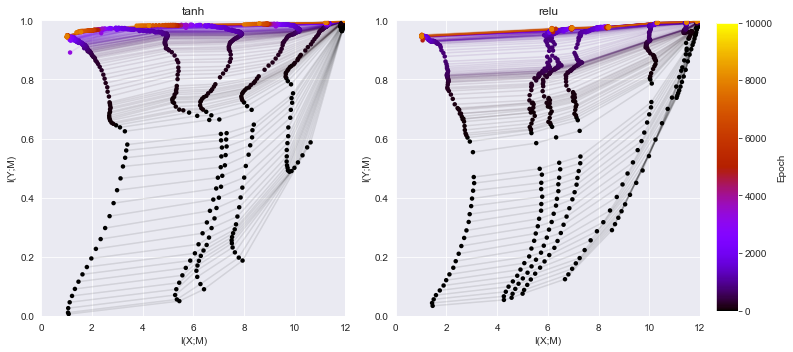

In [4]:
max_epoch = max( (max(vals.keys()) if len(vals) else 0) for vals in measures.values())
sm = plt.cm.ScalarMappable(cmap='gnuplot', norm=plt.Normalize(vmin=0, vmax=COLORBAR_MAX_EPOCHS))
sm._A = []

fig=plt.figure(figsize=(10,5))
for actndx, (activation, vals) in enumerate(measures.items()):
    epochs = sorted(vals.keys())
    if not len(epochs):
        continue
    plt.subplot(1,2,actndx+1)    
    for epoch in epochs:
        c = sm.to_rgba(epoch)
        xmvals = np.array(vals[epoch]['MI_XM_'+infoplane_measure])[PLOT_LAYERS]
        ymvals = np.array(vals[epoch]['MI_YM_'+infoplane_measure])[PLOT_LAYERS]

        plt.plot(xmvals, ymvals, c=c, alpha=0.1, zorder=1)
        plt.scatter(xmvals, ymvals, s=20, facecolors=[c for _ in PLOT_LAYERS], edgecolor='none', zorder=2)

    plt.ylim([0, 1])
    plt.xlim([0, 12])
#     plt.ylim([0, 3.5])
#     plt.xlim([0, 14])
    plt.xlabel('I(X;M)')
    plt.ylabel('I(Y;M)')
    plt.title(activation)
    
cbaxes = fig.add_axes([1.0, 0.125, 0.03, 0.8]) 
plt.colorbar(sm, label='Epoch', cax=cbaxes)
plt.tight_layout()

if DO_SAVE:
    plt.savefig('plots/' + DIR_TEMPLATE % ('infoplane_'+ARCH),bbox_inches='tight')

Plot SNR curves
----

D:\anaconda\envs\keras\lib\site-packages\matplotlib\figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "
D:\anaconda\envs\keras\lib\site-packages\matplotlib\figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "
D:\anaconda\envs\keras\lib\site-packages\matplotlib\figure.py:98: MatplotlibDeprec

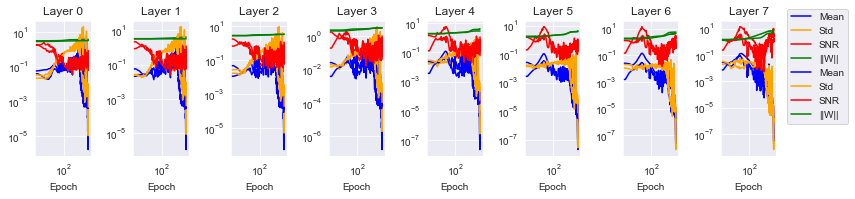

In [5]:
plt.figure(figsize=(12,5))

gs = gridspec.GridSpec(len(measures), len(PLOT_LAYERS))
for activation in measures.keys():
    cur_dir = 'rawdata/' + DIR_TEMPLATE % activation
    if not os.path.exists(cur_dir):
        continue
        
    epochs = []
    means = []
    stds = []
    wnorms = []
    for epochfile in sorted(os.listdir(cur_dir)):
        if not epochfile.startswith('epoch'):
            continue
            
        with open(cur_dir + "/"+epochfile, 'rb') as f:
            d = pickle.load(f)
            
        epoch = d['epoch']
        epochs.append(epoch)
        wnorms.append(d['data']['weights_norm'])
        means.append(d['data']['gradmean'])
        stds.append(d['data']['gradstd'])

    wnorms, means, stds = map(np.array, [wnorms, means, stds])
    for lndx,layerid in enumerate(PLOT_LAYERS):
        plt.subplot(gs[actndx, lndx])
        plt.plot(epochs, means[:,layerid], 'b', label="Mean")
        plt.plot(epochs, stds[:,layerid], 'orange', label="Std")
        plt.plot(epochs, means[:,layerid]/stds[:,layerid], 'red', label="SNR")
        plt.plot(epochs, wnorms[:,layerid], 'g', label="||W||")

        plt.title('Layer %d'%layerid)
        plt.xlabel('Epoch')
        plt.gca().set_xscale("log", nonposx='clip')
        plt.gca().set_yscale("log", nonposy='clip')
    

plt.legend(loc='lower left', bbox_to_anchor=(1.1, 0.2))
plt.tight_layout()

if DO_SAVE:
    plt.savefig('plots/' + DIR_TEMPLATE % ('snr_'+ARCH), bbox_inches='tight')
